# **Sentimen Analisis Review APK Play Store**

# **Import Library**

In [1]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 12.8 MB/s eta 0:00:00


In [2]:
# ==============================
# 📦 Import Library yang Dibutuhkan
# ==============================

# --- General Libraries ---
import os
import re
import string
import csv
import requests
from io import StringIO
import datetime as dt
import numpy as np
import pandas as pd

# --- Google Colab ---
from google.colab import drive  # Akses Google Drive

# --- Visualisasi ---
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# --- Konfigurasi ---
pd.options.mode.chained_assignment = None  # Nonaktifkan warning chaining
np.random.seed(0)  # Seed untuk reproduktibilitas

# ==============================
# 🔤 NLP Libraries
# ==============================

# --- NLTK ---
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# --- Bahasa Indonesia: Sastrawi ---
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# ==============================
# 🤖 Machine Learning Libraries
# =============================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report
)

# ==============================
# 🧠 Deep Learning (TensorFlow / Keras)
# ==============================
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout,
    Conv1D, MaxPooling1D, Flatten, GRU
)
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# **Loading Dataset**

In [3]:
# Mount Google Drive ke Google Colab agar dapat mengakses file di dalamnya
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_reviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Belajar Pengembangan Machine Learning (Submission)/Proyek Pertama/dataset_scraping.csv')
print(f"Jumlah ulasan: {len(df_reviews)}")

Jumlah ulasan: 30000


In [5]:
# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = df_reviews.shape

print(f"Jumlah Ulasan : {jumlah_ulasan}")
print(f"Jumlah Kolom  : {jumlah_kolom}")

Jumlah Ulasan : 30000
Jumlah Kolom  : 11


In [6]:
df_reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,71fd9775-8281-4340-89f0-5de265197b2b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Game buruk, system matchmaking game paling bur...",4,1297,1.9.64.10601,2025-03-28 09:50:38,NaN,NaN,1.9.64.10601
1,d7c2cb2d-48af-4959-999d-d7fff6d7182b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,asli nih game gak danta!! gua udah 7× main di ...,2,991,1.9.64.10601,2025-03-28 14:52:21,NaN,NaN,1.9.64.10601
2,9bd15e3b-7ae1-4827-af1c-f80b9aea4fa2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tiap main rank pasti aja ada player beban/male...,1,11803,1.9.65.10602,2025-03-28 15:42:15,NaN,NaN,1.9.65.10602
3,2cc02e76-efa0-4108-ba9d-e174d7ccc98c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Matchmaking yang sangat buruk ketika bermain s...,1,1324,1.9.64.10601,2025-03-30 01:25:13,NaN,NaN,1.9.64.10601
4,ada60d3f-14b4-4a8d-a3d6-61ae50eebf55,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Pengalaman bermain yang buruk, Game sering fre...",1,2396,1.9.64.10601,2025-03-27 14:23:01,NaN,NaN,1.9.64.10601


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  28411 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          1221 non-null   object
 9   repliedAt             1221 non-null   object
 10  appVersion            28411 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


In [8]:
print(df_reviews.isnull().sum())

reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion     1589
at                          0
replyContent            28779
repliedAt               28779
appVersion               1589
dtype: int64


In [9]:
# Membuat DataFrame baru (df_reviews_clean) dengan menghapus kolom yang memiliki nilai yang hilang (NaN) dari df_reviews
df_reviews_clean = df_reviews.drop(columns=['replyContent', 'repliedAt', 'reviewCreatedVersion', 'appVersion'])

In [10]:
df_reviews_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviewId       30000 non-null  object
 1   userName       30000 non-null  object
 2   userImage      30000 non-null  object
 3   content        30000 non-null  object
 4   score          30000 non-null  int64 
 5   thumbsUpCount  30000 non-null  int64 
 6   at             30000 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.6+ MB


In [11]:
# Menghapus baris duplikat dari DataFrame clean_df
df_reviews_clean = df_reviews_clean.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = df_reviews_clean.shape

print(f"Jumlah Ulasan : {jumlah_ulasan_setelah_hapus_duplikat}")
print(f"Jumlah Kolom  : {jumlah_kolom_setelah_hapus_duplikat}")

Jumlah Ulasan : 30000
Jumlah Kolom  : 7


## **Preprocessing**

In [12]:
def cleaningText(text):
    # Menghapus mentions, hashtag, retweet tag (RT), URL, angka, dan karakter selain huruf dan spasi
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # hashtag
    text = re.sub(r'RT[\s]', '', text) # RT
    text = re.sub(r"http\S+", '', text) # URL
    text = re.sub(r'[0-9]+', '', text) # angka
    text = re.sub(r'[^\w\s]', '', text) # karakter selain huruf dan spasi


    text = text.replace('\n', ' ') # Menghilangkan newline
    text = text.translate(str.maketrans('', '', string.punctuation)) # Menghapus semua tanda baca
    text = text.strip(' ') # Menghapus spasi di awal dan akhir
    return text

def emojiRemove(text):
    # Pola unicode untuk menghapus emoji dan simbol
    emoji_pattern = re.compile(
        "["
        "\U0001F1E0-\U0001F1FF"
        "\U0001F300-\U0001F5FF"
        "\U0001F600-\U0001F64F"
        "\U0001F680-\U0001F6FF"
        "\U0001F700-\U0001F77F"
        "\U0001F780-\U0001F7FF"
        "\U0001F800-\U0001F8FF"
        "\U0001F900-\U0001F9FF"
        "\U0001FA00-\U0001FA6F"
        "\U0001FA70-\U0001FAFF"
        "\U00002600-\U000026FF"
        "\U00002700-\U000027BF"
        "\U00002B00-\U00002BFF"
        "\U00002300-\U000023FF"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub('', text)

def casefoldingText(text): # Mengubah seluruh teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah kalimat menjadi kata
    text = word_tokenize(text)
    return text

def filteringText(text): # Mengambil daftar stopword dari dua bahasa
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','rb','ny','nya','na','sih','ku','ga','ya','gaa', 'loh','kah','woi','woii','woy']) # Menambahkan kata-kata tambahan yang dianggap tidak penting

    # Menghapus kata-kata yang ada di dalam daftar stopword
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):  # Gabungkan daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [13]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "dc": "disconnect", "noob": "pemula", "bocil": "anak kecil", "random": "acak", "lag": "lambat", "tolol": "bodoh", "gblk": "goblok", "gg": "good game", "udh": "sudah", "rank": "peringkat", "mabar": "main bareng", "cmn": "cuman", "afk": "tidak aktif", "ez": "mudah", "win": "menang", "lose": "kalah", "blunder": "kesalahan", "sinyal": "koneksi", "gang": "keroyokan", "report": "laporkan", "turu": "tidur", "auto": "otomatis", "relog": "masuk ulang", "login": "masuk", "logout": "keluar", "redup": "menurun", "toxic": "kasar", "delay": "terlambat", "surrend": "menyerah", "cd": "cooldown", "ks": "mencuri kill", "skin": "kostum hero", "bait": "memancing lawan", "rip": "meninggal", "map": "peta", "cupu": "lemah", "lane": "jalur", "mid": "tengah", "modyar": "mati", "tumbal": "pengorbanan"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [14]:
df_reviews_clean

,reviewId,userName,userImage,content,score,thumbsUpCount,at
0,71fd9775-8281-4340-89f0-5de265197b2b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Game buruk, system matchmaking game paling bur...",4,1297,2025-03-28 09:50:38
1,d7c2cb2d-48af-4959-999d-d7fff6d7182b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,asli nih game gak danta!! gua udah 7× main di ...,2,991,2025-03-28 14:52:21
2,9bd15e3b-7ae1-4827-af1c-f80b9aea4fa2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tiap main rank pasti aja ada player beban/male...,1,11803,2025-03-28 15:42:15
3,2cc02e76-efa0-4108-ba9d-e174d7ccc98c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Matchmaking yang sangat buruk ketika bermain s...,1,1324,2025-03-30 01:25:13
4,ada60d3f-14b4-4a8d-a3d6-61ae50eebf55,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Pengalaman bermain yang buruk, Game sering fre...",1,2396,2025-03-27 14:23:01
...,...,...,...,...,...,...,...
29995,5219d706-39c9-49a1-9b18-e28b0c84613b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Makin gx nyaman main, karna masalah jaringan y...",1,0,2020-03-19 19:30:01
29996,0d5df882-70e7-4801-9c85-42af81c82a03,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Hanya satu yg membuat saya kecewa sistem match...,4,0,2020-10-23 04:55:59
29997,490c4c9e-1b20-4c87-afd0-b97146eb0090,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sering terjadi bug di saat mode ranked yang ke...,4,3,2020-06-29 06:30:45
29998,807a3beb-5183-45a4-8195-bb85d125886f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sinyal masih perlu diperbaiki lagi, karena pak...",3,0,2020-09-10 13:22:11


In [15]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df_reviews_clean['text_clean'] = df_reviews_clean['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df_reviews_clean['text_casefoldingText'] = df_reviews_clean['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df_reviews_clean['text_slangwords'] = df_reviews_clean['text_casefoldingText'].apply(fix_slangwords)

# Menerapkan fungsi emojiRemove ke setiap elemen dalam kolom 'text_slangwords'
df_reviews_clean['text_emojiRemove'] = df_reviews_clean['text_slangwords'].apply(emojiRemove)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizing'
df_reviews_clean['text_tokenizingText'] = df_reviews_clean['text_emojiRemove'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df_reviews_clean['text_stopword'] = df_reviews_clean['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df_reviews_clean['text_akhir'] = df_reviews_clean['text_stopword'].apply(toSentence)

In [16]:
df_reviews_clean

,reviewId,userName,userImage,content,score,thumbsUpCount,at,text_clean,text_casefoldingText,text_slangwords,text_emojiRemove,text_tokenizingText,text_stopword,text_akhir
0,71fd9775-8281-4340-89f0-5de265197b2b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Game buruk, system matchmaking game paling bur...",4,1297,2025-03-28 09:50:38,Game buruk system matchmaking game paling buru...,game buruk system matchmaking game paling buru...,game buruk system matchmaking game paling buru...,game buruk system matchmaking game paling buru...,"[game, buruk, system, matchmaking, game, palin...","[game, buruk, system, matchmaking, game, buruk...",game buruk system matchmaking game buruk penye...
1,d7c2cb2d-48af-4959-999d-d7fff6d7182b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,asli nih game gak danta!! gua udah 7× main di ...,2,991,2025-03-28 14:52:21,asli nih game gak danta gua udah main di rank...,asli nih game gak danta gua udah main di rank...,asli ini game gak danta saya sudah main di per...,asli ini game gak danta saya sudah main di per...,"[asli, ini, game, gak, danta, saya, sudah, mai...","[asli, game, danta, main, peringkat, ngebug, b...",asli game danta main peringkat ngebug bae gera...
2,9bd15e3b-7ae1-4827-af1c-f80b9aea4fa2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tiap main rank pasti aja ada player beban/male...,1,11803,2025-03-28 15:42:15,tiap main rank pasti aja ada player bebanmales...,tiap main rank pasti aja ada player bebanmales...,tiap main peringkat pasti saja ada player beba...,tiap main peringkat pasti saja ada player beba...,"[tiap, main, peringkat, pasti, saja, ada, play...","[main, peringkat, player, bebanmales, main, pl...",main peringkat player bebanmales main player p...
3,2cc02e76-efa0-4108-ba9d-e174d7ccc98c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Matchmaking yang sangat buruk ketika bermain s...,1,1324,2025-03-30 01:25:13,Matchmaking yang sangat buruk ketika bermain s...,matchmaking yang sangat buruk ketika bermain s...,matchmaking yang sangat buruk ketika bermain s...,matchmaking yang sangat buruk ketika bermain s...,"[matchmaking, yang, sangat, buruk, ketika, ber...","[matchmaking, buruk, bermain, solo, gangguan, ...",matchmaking buruk bermain solo gangguan koneks...
4,ada60d3f-14b4-4a8d-a3d6-61ae50eebf55,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Pengalaman bermain yang buruk, Game sering fre...",1,2396,2025-03-27 14:23:01,Pengalaman bermain yang buruk Game sering free...,pengalaman bermain yang buruk game sering free...,pengalaman bermain yang buruk game sering free...,pengalaman bermain yang buruk game sering free...,"[pengalaman, bermain, yang, buruk, game, serin...","[pengalaman, bermain, buruk, game, freezing, d...",pengalaman bermain buruk game freezing ditenga...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,5219d706-39c9-49a1-9b18-e28b0c84613b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Makin gx nyaman main, karna masalah jaringan y...",1,0,2020-03-19 19:30:01,Makin gx nyaman main karna masalah jaringan ya...,makin gx nyaman main karna masalah jaringan ya...,makin gx nyaman main karena masalah jaringan y...,makin gx nyaman main karena masalah jaringan y...,"[makin, gx, nyaman, main, karena, masalah, jar...","[gx, nyaman, main, jaringan, gx, stabil, kadan...",gx nyaman main jaringan gx stabil kadang pas w...
29996,0d5df882-70e7-4801-9c85-42af81c82a03,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Hanya satu yg membuat saya kecewa sistem match...,4,0,2020-10-23 04:55:59,Hanya satu yg membuat saya kecewa sistem match...,hanya satu yg membuat saya kecewa sistem match...,hanya satu yang membuat saya kecewa sistem mat...,hanya satu yang membuat saya kecewa sistem mat...,"[hanya, satu, yang, membuat, saya, kecewa, sis...","[kecewa, sistem, match, making, moonton, tolon...",kecewa sistem match making moonton tolong kebi...
29997,490c4c

## **Pelabelan**

In [17]:
def load_lexicon(url):
    lexicon = {}

    # Kirim request ke URL yang berisi file CSV lexicon
    response = requests.get(url)

    if response.status_code == 200:
        # Baca isi response sebagai CSV
        csv_text = StringIO(response.text)
        reader = csv.reader(csv_text, delimiter=',')

        # Simpan kata dan skor ke dalam dictionary lexicon
        for row in reader:
            if row:  # Hindari baris kosong
                lexicon[row[0]] = int(row[1])
    else:
        print(f"[Error] Tidak dapat mengambil data dari: {url}")

    return lexicon

# URL CSV dari GitHub untuk lexicon positif dan negatif
positive_lexicon_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
negative_lexicon_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

# Load kamus kata-kata positif dan negatif
lexicon_positive = load_lexicon(positive_lexicon_url)
lexicon_negative = load_lexicon(negative_lexicon_url)

In [18]:
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    # Inisialisasi variabel polaritas
    polarity=''

    if (score > 0):
        polarity = 'positive' # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative' # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
    else:
        polarity = 'neutral' # Jika skor sentimen sama dengan 0, maka polaritas adalah netral

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [19]:
results = df_reviews_clean['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df_reviews_clean['polarity_score'] = results[0]
df_reviews_clean['polarity'] = results[1]
print(df_reviews_clean['polarity'].value_counts())

polarity
negative    19997
positive     8413
neutral      1590
Name: count, dtype: int64


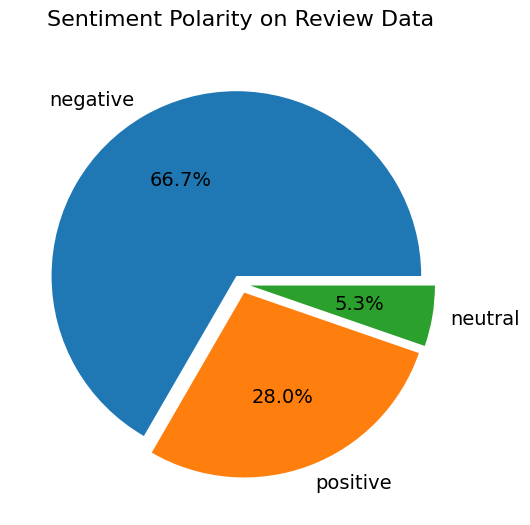

In [20]:
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'df_gojek_reviews_cleaned' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in df_reviews_clean['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'df_gojek_reviews_cleaned' dan menyimpannya dalam list 'labels'.
labels = list(df_reviews_clean['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = (0.05, 0.05, 0.05)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

In [21]:
# Atur agar kolom pada DataFrame bisa menampilkan teks panjang (hingga 5000 karakter)
pd.set_option('display.max_colwidth', 5000)

# Fungsi untuk memfilter tweet berdasarkan jenis sentimen
def process_tweets(df, sentiment):
    # Ambil kolom penting dari tweet dengan sentimen tertentu
    filtered_tweets = df[df['polarity'] == sentiment][['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]

    # Urutkan berdasarkan skor polaritas dari tertinggi ke terendah
    filtered_tweets = filtered_tweets.sort_values(by='polarity_score', ascending=False).reset_index(drop=True)

    # Mulai index dari 1 (biar lebih rapi saat ditampilkan)
    filtered_tweets.index += 1
    return filtered_tweets

# Buat DataFrame terpisah untuk tiap kategori sentimen
positive_tweets = process_tweets(df_reviews_clean, 'positive')
negative_tweets = process_tweets(df_reviews_clean, 'negative')
neutral_tweets = process_tweets(df_reviews_clean, 'neutral')

In [22]:
def render_text_wordcloud(dataframe, title):
    # Gabungkan semua kata dari kolom 'text_stopword'
    combined_text = ' '.join(
        ' '.join(item) if isinstance(item, list) else item
        for item in dataframe['text_stopword']
    )

    # Buat objek WordCloud dari teks gabungan
    wordcloud = WordCloud(
        width=600,              # Lebar gambar wordcloud
        height=400,             # Tinggi gambar wordcloud
        background_color='white',  # Latar belakang putih
        min_font_size=10        # Ukuran font minimal
    ).generate(combined_text)

    # Tampilkan wordcloud dengan matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title, fontsize=18)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.grid(False)
    fig.tight_layout(pad=0)
    plt.show()

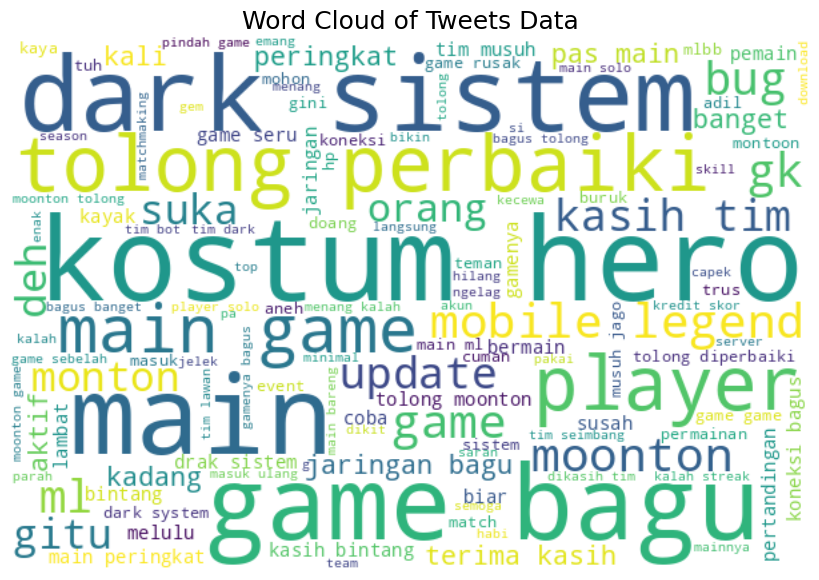

In [23]:
# Visualisasi kumpulan kata dari semua tweet (positif, negatif, dan netral)
render_text_wordcloud(df_reviews_clean, 'Word Cloud of Tweets Data')

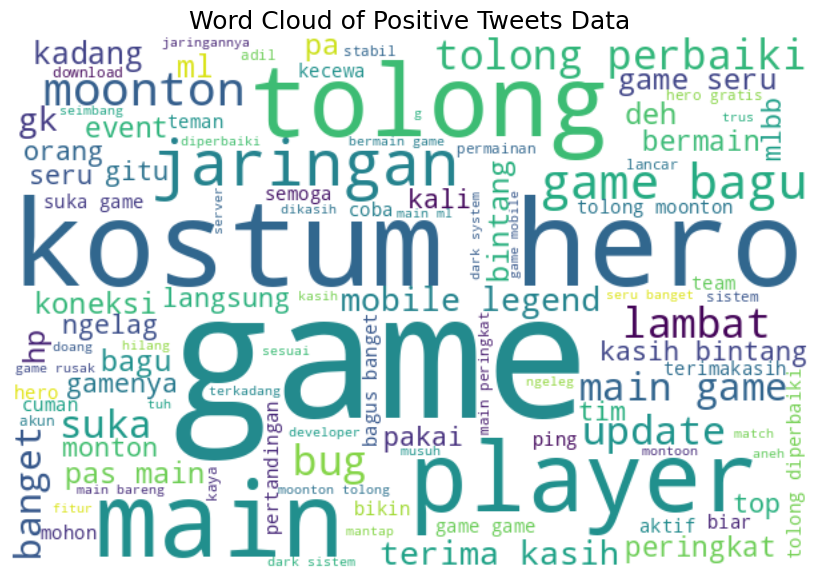

In [24]:
# Visualisasi kumpulan kata dari tweet dengan sentimen positif
render_text_wordcloud(positive_tweets, 'Word Cloud of Positive Tweets Data')

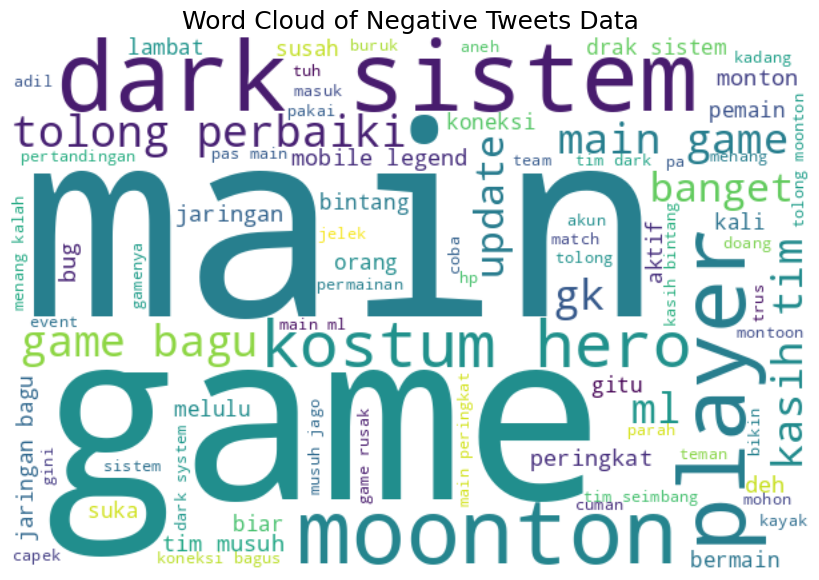

In [25]:
# Visualisasi kumpulan kata dari tweet dengan sentimen negatif
render_text_wordcloud(negative_tweets, 'Word Cloud of Negative Tweets Data')

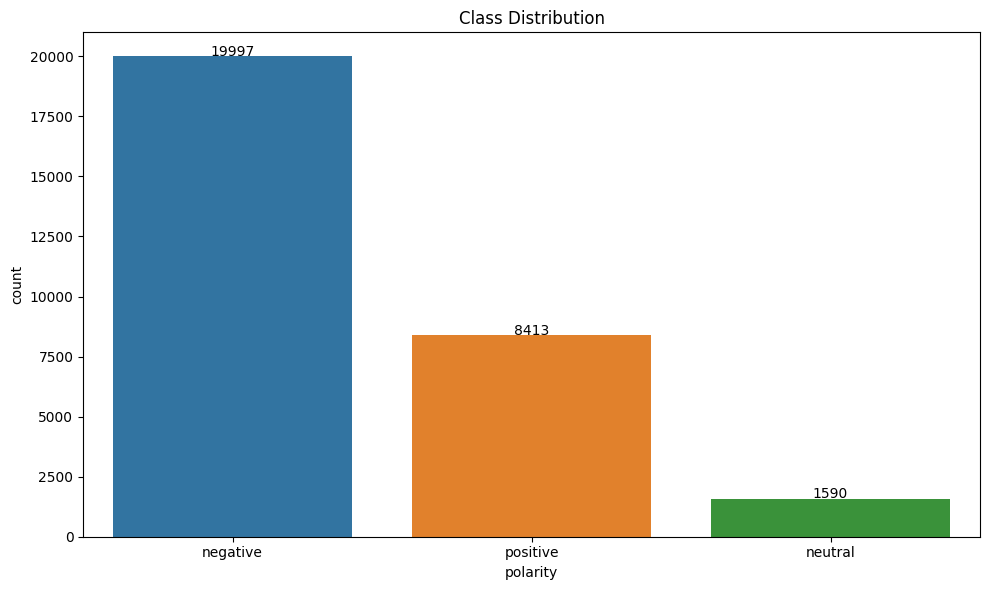

In [26]:
# --- Class Distribution (Positive, Negative, Neutral) ---
plt.figure(figsize=(10, 6))
sentiment_count = sns.countplot(data=df_reviews_clean, x='polarity', hue='polarity', legend=False)
plt.title('Class Distribution')

# Tambahkan jumlah di atas setiap batang
for bar in sentiment_count.patches:
    sentiment_count.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 5,
        f'{int(bar.get_height())}',
        ha='center'
    )

plt.tight_layout()
plt.show()

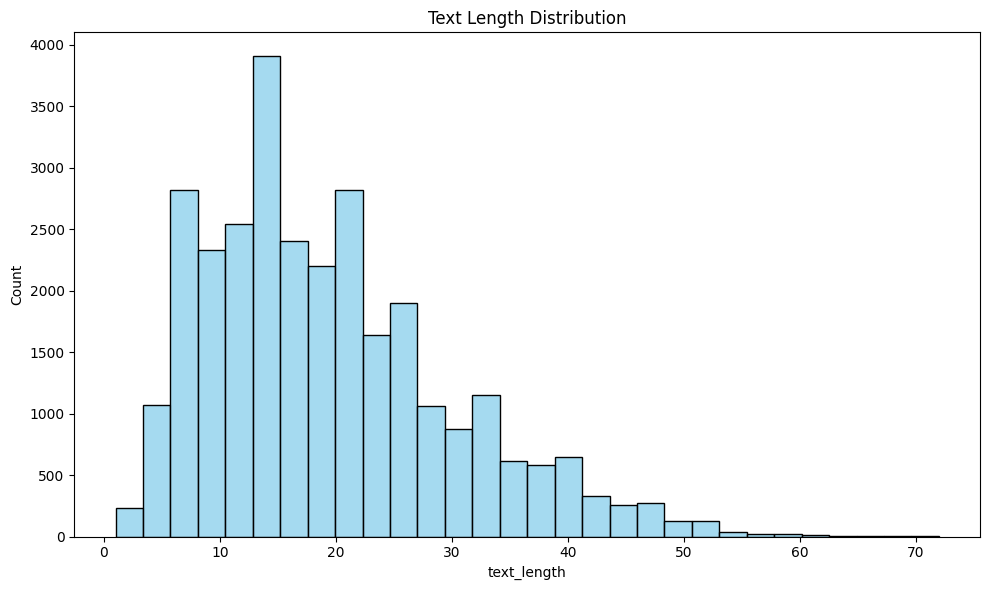

In [27]:
# --- Text Length Distribution ---
plt.figure(figsize=(10, 6))
df_reviews_clean['text_length'] = df_reviews_clean['text_akhir'].apply(lambda text: len(text.split()))
sns.histplot(df_reviews_clean['text_length'], bins=30, color='skyblue')
plt.title('Text Length Distribution')
plt.tight_layout()
plt.show()

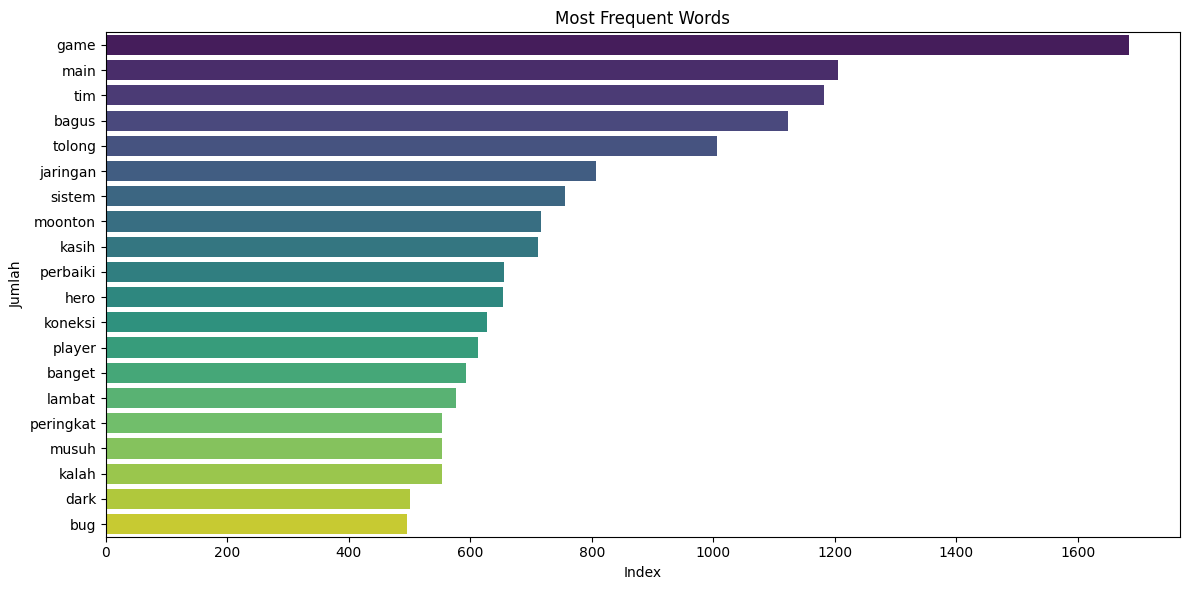

In [28]:
# --- Most Frequent Words ---
plt.figure(figsize=(12, 6))

# Gunakan TF-IDF untuk menghitung kata-kata penting
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_reviews_clean['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Jumlahkan skor TF-IDF untuk setiap kata dan ambil 20 teratas
top_words = tfidf_df.sum().sort_values(ascending=False).head(20).reset_index()
top_words.columns = ['word', 'tfidf_df']

# Tambahkan kolom hue dummy
top_words['hue_dummy'] = top_words['word']

# Visualisasikan dengan barplot horizontal
sns.barplot(data=top_words, x='tfidf_df', y='word', hue='hue_dummy', palette='viridis', legend=False)

plt.title('Most Frequent Words')
plt.xlabel('Index')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

## **Data Splitting**

In [29]:
df_reviews_clean.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,at,text_clean,text_casefoldingText,text_slangwords,text_emojiRemove,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity,text_length
0,71fd9775-8281-4340-89f0-5de265197b2b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"Game buruk, system matchmaking game paling buruk yg pernah ada, penyeimbangan tim tidak setara. Setelah win 1x selanjutnya pasti lose 2x atau lebih, stuck dan terus berputar"" seperti itu. Jika tidak ada perbaikan mengenai penyeimbangan matchmaking, game ini akan menjadi game moba dengan matchmaking terburuk yang pernah ada.",4,1297,2025-03-28 09:50:38,Game buruk system matchmaking game paling buruk yg pernah ada penyeimbangan tim tidak setara Setelah win x selanjutnya pasti lose x atau lebih stuck dan terus berputar seperti itu Jika tidak ada perbaikan mengenai penyeimbangan matchmaking game ini akan menjadi game moba dengan matchmaking terburuk yang pernah ada,game buruk system matchmaking game paling buruk yg pernah ada penyeimbangan tim tidak setara setelah win x selanjutnya pasti lose x atau lebih stuck dan terus berputar seperti itu jika tidak ada perbaikan mengenai penyeimbangan matchmaking game ini akan menjadi game moba dengan matchmaking terburuk yang pernah ada,game buruk system matchmaking game paling buruk yang pernah ada penyeimbangan tim tidak setara setelah menang x selanjutnya pasti kalah x atau lebih stuck dan terus berputar seperti itu jika tidak ada perbaikan mengenai penyeimbangan matchmaking game ini akan menjadi game moba dengan matchmaking terburuk yang pernah ada,game buruk system matchmaking game paling buruk yang pernah ada penyeimbangan tim tidak setara setelah menang x selanjutnya pasti kalah x atau lebih stuck dan terus berputar seperti itu jika tidak ada perbaikan mengenai penyeimbangan matchmaking game ini akan menjadi game moba dengan matchmaking terburuk yang pernah ada,"[game, buruk, system, matchmaking, game, paling, buruk, yang, pernah, ada, penyeimbangan, tim, tidak, setara, setelah, menang, x, selanjutnya, pasti, kalah, x, atau, lebih, stuck, dan, terus, berputar, seperti, itu, jika, tidak, ada, perbaikan, mengenai, penyeimbangan, matchmaking, game, ini, akan, menjadi, game, moba, dengan, matchmaking, terburuk, yang, pernah, ada]","[game, buruk, system, matchmaking, game, buruk, penyeimbangan, tim, setara, menang, x, kalah, x, stuck, berputar, perbaikan, penyeimbangan, matchmaking, game, game, moba, matchmaking, terburuk]",game buruk system matchmaking game buruk penyeimbangan tim setara menang x kalah x stuck berputar perbaikan penyeimbangan matchmaking game game moba matchmaking terburuk,-6,negative,23
1,d7c2cb2d-48af-4959-999d-d7fff6d7182b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"asli nih game gak danta!! gua udah 7× main di rank terus ngebug Bae. kaga bisa gerak samsek. giliran gua buka apk lainnya bisa berfungsi dengan baik. tolong moonton perbaiki lagi nih game, jangan buat rusak nih game dan sistem tim nya, tolong di benahi lagi. jangan lu satuin orang yang cuma bisa mm atau jungler. pisahin semua!!!!",2,991,2025-03-28 14:52:21,asli nih game gak danta gua udah main di rank terus ngebug Bae kaga bisa gerak samsek giliran gua buka apk lainnya bisa berfungsi dengan baik tolong moonton perbaiki lagi nih game jangan buat rusak nih game dan sistem tim nya tolong di benahi lagi jangan lu satuin orang yang cuma bisa mm atau jungler pisahin semua,asli nih game gak danta gua udah main di rank terus ngebug bae kaga bisa gerak samsek giliran gua buka apk lainnya bisa berfungsi dengan baik tolong moonton perbaiki lagi nih game jangan buat rusak nih game dan sistem tim nya tolong di benahi lagi jangan lu satuin orang yang cuma bisa mm atau jungler pisahin semua,asli ini game gak danta saya sudah main di peringkat terus ngebu

In [30]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = df_reviews_clean['text_akhir'] # Kolom teks bersih
y_raw = df_reviews_clean['polarity'] # Kolom sentimen (positif, negatif)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

In [31]:
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


In [32]:
# Callback EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Callback Custom (akurasi >92%)
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.92:
            print("\nAkurasi telah mencapai >92%! Training dihentikan.")
            self.model.stop_training = True
custom_callback = MyCallback()

## **Modelling**

### **Skema 1: CNN + Split 80/20**

In [33]:
# Split data menjadi set pelatihan dan set uji
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(X, y, test_size=0.2, random_state=42)

# Tampilkan bentuk set pelatihan dan set uji untuk memastikan split
print(f"Training set shape  : X_train={X_train_CNN.shape}, y_train={y_train_CNN.shape}")
print(f"Test set shape      : X_test={X_test_CNN.shape}, y_test={y_test_CNN.shape}")

Training set shape  : X_train=(24000,), y_train=(24000,)
Test set shape      : X_test=(6000,), y_test=(6000,)


In [34]:
# Parameter untuk tokenizer dan padding
max_words = 2500
max_len = 100
tokenizer_CNN = Tokenizer(num_words=max_words)
tokenizer_CNN.fit_on_texts(X_train_CNN)

# Tokenisasi
X_train_sequences_CNN = tokenizer_CNN.texts_to_sequences(X_train_CNN)
X_test_sequences_CNN = tokenizer_CNN.texts_to_sequences(X_test_CNN)

# Padding sequence
X_train_padded_CNN = pad_sequences(X_train_sequences_CNN, maxlen=max_len)
X_test_padded_CNN = pad_sequences(X_test_sequences_CNN, maxlen=max_len)

# One-hot encoding untuk label
y_train_cat_CNN = pd.get_dummies(y_train_CNN).values
y_test_cat_CNN = pd.get_dummies(y_test_CNN).values

In [35]:
# Bangun model CNN
model_CNN = Sequential()
model_CNN.add(Embedding(input_dim=max_words, output_dim=128))
model_CNN.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_CNN.add(Dropout(0.3))
model_CNN.add(Dense(3, activation='softmax'))

# Kompilasi model
model_CNN.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Latih model
history_CNN = model_CNN.fit(
    X_train_padded_CNN, y_train_cat_CNN,
    epochs=30,
    batch_size=96,
    validation_data=(X_test_padded_CNN, y_test_cat_CNN),
    callbacks=[early_stop],
    verbose=2
)

loss_CNN, accuracy_CNN = model_CNN.evaluate(X_test_padded_CNN, y_test_cat_CNN, verbose=0)
print(f"Test Loss     : {loss_CNN:.4f}")
print(f"Test Accuracy : {accuracy_CNN:.4f}")

# Evaluasi model - Skema 2: CNN
y_pred_probs_CNN = model_CNN.predict(X_test_padded_CNN)
y_pred_CNN = np.argmax(y_pred_probs_CNN, axis=1)
y_true_CNN = np.argmax(y_test_cat_CNN, axis=1)

# Label mapping
label_names = ['positive', 'negative', 'neutral']

print("Evaluasi Model CNN: ")
print(f"Accuracy  : {accuracy_score(y_true_CNN, y_pred_CNN):.2f}")
print(f"Precision : {precision_score(y_true_CNN, y_pred_CNN, average='weighted'):.2f}")
print(f"Recall    : {recall_score(y_true_CNN, y_pred_CNN, average='weighted'):.2f}")
print(f"F1 Score  : {f1_score(y_true_CNN, y_pred_CNN, average='weighted'):.2f}\n")

print("Classification Report: ")
print(classification_report(y_true_CNN, y_pred_CNN, target_names=label_names, digits=2))

# Akurasi dari history
train_acc_CNN = history_CNN.history['accuracy'][-1]
print("Akurasi pada training set Model CNN : %.4f" % (train_acc_CNN))
print("Akurasi pada test set Model CNN     : %.4f" % (accuracy_CNN))

Epoch 1/30
250/250 - 9s - 37ms/step - accuracy: 0.7924 - loss: 0.7138 - val_accuracy: 0.8695 - val_loss: 0.3963
Epoch 2/30
250/250 - 4s - 17ms/step - accuracy: 0.8936 - loss: 0.3261 - val_accuracy: 0.8852 - val_loss: 0.3399
Epoch 3/30
250/250 - 1s - 6ms/step - accuracy: 0.9113 - loss: 0.2636 - val_accuracy: 0.8910 - val_loss: 0.3173
Epoch 4/30
250/250 - 2s - 9ms/step - accuracy: 0.9242 - loss: 0.2240 - val_accuracy: 0.8863 - val_loss: 0.3465
Epoch 5/30
250/250 - 1s - 4ms/step - accuracy: 0.9366 - loss: 0.1901 - val_accuracy: 0.8907 - val_loss: 0.3813
Epoch 6/30
250/250 - 1s - 5ms/step - accuracy: 0.9436 - loss: 0.1771 - val_accuracy: 0.8835 - val_loss: 0.4011
Epoch 7/30
250/250 - 1s - 4ms/step - accuracy: 0.9522 - loss: 0.1524 - val_accuracy: 0.8852 - val_loss: 0.4278
Epoch 8/30
250/250 - 1s - 5ms/step - accuracy: 0.9601 - loss: 0.1322 - val_accuracy: 0.8820 - val_loss: 0.5094
Test Loss     : 0.3173
Test Accuracy : 0.8910
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Evaluasi Model CNN: 
Ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

### **Skema 2: GRU + Split 90/10**

In [36]:
# Split data menjadi set pelatihan dan set uji
X_train_GRU, X_test_GRU, y_train_GRU, y_test_GRU = train_test_split(X, y, test_size=0.1)


# Tampilkan bentuk set pelatihan dan set uji untuk memastikan split
print(f"Training set shape  : X_train={X_train_GRU.shape}, y_train={y_train_GRU.shape}")
print(f"Test set shape      : X_test={X_test_GRU.shape}, y_test={y_test_GRU.shape}")

Training set shape  : X_train=(27000,), y_train=(27000,)
Test set shape      : X_test=(3000,), y_test=(3000,)


In [37]:
# Parameter untuk tokenizer dan padding
max_words = 2500
max_len = 100
tokenizer_GRU = Tokenizer(num_words=max_words)
tokenizer_GRU.fit_on_texts(X_train_GRU)

# Tokenisasi
X_train_sequences_GRU = tokenizer_GRU.texts_to_sequences(X_train_GRU)
X_test_sequences_GRU = tokenizer_GRU.texts_to_sequences(X_test_GRU)

# Padding sequence
X_train_padded_GRU = pad_sequences(X_train_sequences_GRU, maxlen=max_len)
X_test_padded_GRU = pad_sequences(X_test_sequences_GRU, maxlen=max_len)

# One-hot encoding untuk label
y_train_cat_GRU = pd.get_dummies(y_train_GRU).values
y_test_cat_GRU = pd.get_dummies(y_test_GRU).values

In [38]:
# Bangun model GRU
model_GRU = Sequential()
model_GRU.add(Embedding(input_dim=max_words, output_dim=128))
model_GRU.add(GRU(64, dropout=0.2, kernel_regularizer=l2(0.01)))
model_GRU.add(Dense(64, activation='relu'))
model_GRU.add(Dropout(0.3))
model_GRU.add(Dense(32, activation='relu'))
model_GRU.add(Dropout(0.3))
model_GRU.add(Dense(3, activation='softmax'))

# Kompilasi model
model_GRU.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Latih model
history_GRU = model_GRU.fit(
    X_train_padded_GRU, y_train_cat_GRU,
    epochs=30,
    batch_size=96,
    validation_data=(X_test_padded_GRU, y_test_cat_GRU),
    callbacks=[early_stop],
    verbose=2
)

loss_GRU, accuracy_GRU = model_GRU.evaluate(X_test_padded_GRU, y_test_cat_GRU, verbose=0)
print(f"Test Loss     : {loss_GRU:.4f}")
print(f"Test Accuracy : {accuracy_GRU:.4f}")

# Evaluasi model - Skema 3: GRU
y_pred_probs_GRU = model_GRU.predict(X_test_padded_GRU)
y_pred_GRU = np.argmax(y_pred_probs_GRU, axis=1)
y_true_GRU = np.argmax(y_test_cat_GRU, axis=1)

# Label mapping
label_names = ['positive', 'negative', 'neutral']

print("Evaluasi Model GRU: ")
print(f"Accuracy  : {accuracy_score(y_true_GRU, y_pred_GRU):.2f}")
print(f"Precision : {precision_score(y_true_GRU, y_pred_GRU, average='weighted'):.2f}")
print(f"Recall    : {recall_score(y_true_GRU, y_pred_GRU, average='weighted'):.2f}")
print(f"F1 Score  : {f1_score(y_true_GRU, y_pred_GRU, average='weighted'):.2f}\n")

print("Classification Report: ")
print(classification_report(y_true_GRU, y_pred_GRU, target_names=label_names, digits=2))

# Akurasi dari history
train_acc_GRU = history_GRU.history['accuracy'][-1]
print("Akurasi pada training set Model GRU : %.4f" % (train_acc_GRU))
print("Akurasi pada test set Model GRU     : %.4f" % (accuracy_GRU))

Epoch 1/30
282/282 - 9s - 34ms/step - accuracy: 0.7760 - loss: 0.8373 - val_accuracy: 0.8507 - val_loss: 0.4137
Epoch 2/30
282/282 - 2s - 8ms/step - accuracy: 0.8857 - loss: 0.3443 - val_accuracy: 0.8937 - val_loss: 0.3124
Epoch 3/30
282/282 - 2s - 9ms/step - accuracy: 0.9050 - loss: 0.2831 - val_accuracy: 0.9003 - val_loss: 0.2967
Epoch 4/30
282/282 - 3s - 12ms/step - accuracy: 0.9141 - loss: 0.2578 - val_accuracy: 0.9023 - val_loss: 0.2836
Epoch 5/30
282/282 - 2s - 9ms/step - accuracy: 0.9196 - loss: 0.2389 - val_accuracy: 0.9133 - val_loss: 0.2757
Epoch 6/30
282/282 - 2s - 8ms/step - accuracy: 0.9247 - loss: 0.2277 - val_accuracy: 0.9073 - val_loss: 0.2810
Epoch 7/30
282/282 - 2s - 8ms/step - accuracy: 0.9290 - loss: 0.2145 - val_accuracy: 0.9117 - val_loss: 0.2740
Epoch 8/30
282/282 - 3s - 9ms/step - accuracy: 0.9305 - loss: 0.2075 - val_accuracy: 0.9090 - val_loss: 0.2785
Epoch 9/30
282/282 - 4s - 13ms/step - accuracy: 0.9343 - loss: 0.2014 - val_accuracy: 0.9140 - val_loss: 0.275

### **Skema 3: LSTM + Split 80/20**

In [39]:
# Split data menjadi set pelatihan dan set uji
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(X, y, test_size=0.2, random_state=42)

# Tampilkan bentuk set pelatihan dan set uji untuk memastikan split
print(f"Training set shape  : X_train={X_train_LSTM.shape}, y_train={y_train_LSTM.shape}")
print(f"Test set shape      : X_test={X_test_LSTM.shape}, y_test={y_test_LSTM.shape}")

Training set shape  : X_train=(24000,), y_train=(24000,)
Test set shape      : X_test=(6000,), y_test=(6000,)


In [40]:
# Parameter untuk tokenizer dan padding
max_words = 2500
max_len = 100
tokenizer_LSTM = Tokenizer(num_words=max_words)
tokenizer_LSTM.fit_on_texts(X_train_LSTM)

# Tokenisasi
X_train_sequences_LSTM = tokenizer_LSTM.texts_to_sequences(X_train_LSTM)
X_test_sequences_LSTM = tokenizer_LSTM.texts_to_sequences(X_test_LSTM)

# Padding sequence
X_train_padded_LSTM = pad_sequences(X_train_sequences_LSTM, maxlen=max_len)
X_test_padded_LSTM = pad_sequences(X_test_sequences_LSTM, maxlen=max_len)

# One-hot encoding untuk label
y_train_cat_LSTM = pd.get_dummies(y_train_LSTM).values
y_test_cat_LSTM = pd.get_dummies(y_test_LSTM).values

In [41]:
# Bangun model LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=max_words, output_dim=128))
model_LSTM.add(LSTM(64, dropout=0.2, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dropout(0.3))
model_LSTM.add(Dense(32, activation='relu'))
model_LSTM.add(Dropout(0.3))
model_LSTM.add(Dense(3, activation='softmax'))

# Kompilasi model
model_LSTM.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Latih model
history_LSTM = model_LSTM.fit(
    X_train_padded_LSTM, y_train_cat_LSTM,
    epochs=30,
    batch_size=96,
    validation_data=(X_test_padded_LSTM, y_test_cat_LSTM),
    callbacks=[early_stop],
    verbose=2
)

loss_LSTM, accuracy_LSTM = model_LSTM.evaluate(X_test_padded_LSTM, y_test_cat_LSTM, verbose=0)
print(f"Test Loss     : {loss_LSTM:.4f}")
print(f"Test Accuracy : {accuracy_LSTM:.4f}")

# Evaluasi model - Skema 1: LSTM
y_pred_probs_LSTM = model_LSTM.predict(X_test_padded_LSTM)
y_pred_LSTM = np.argmax(y_pred_probs_LSTM, axis=1)
y_true_LSTM = np.argmax(y_test_cat_LSTM, axis=1)

# Label mapping
label_names = ['positive', 'negative', 'neutral']

print("Evaluasi Model LSTM: ")
print(f"Accuracy  : {accuracy_score(y_true_LSTM, y_pred_LSTM):.2f}")
print(f"Precision : {precision_score(y_true_LSTM, y_pred_LSTM, average='weighted'):.2f}")
print(f"Recall    : {recall_score(y_true_LSTM, y_pred_LSTM, average='weighted'):.2f}")
print(f"F1 Score  : {f1_score(y_true_LSTM, y_pred_LSTM, average='weighted'):.2f}\n")

print("Classification Report: ")
print(classification_report(y_true_LSTM, y_pred_LSTM, target_names=label_names, digits=2))

# Akurasi dari history
train_acc_LSTM = history_LSTM.history['accuracy'][-1]
print("Akurasi pada training set Model LSTM : %.4f" % (train_acc_LSTM))
print("Akurasi pada test set Model LSTM     : %.4f" % (accuracy_LSTM))

Epoch 1/30
250/250 - 5s - 20ms/step - accuracy: 0.7571 - loss: 0.8692 - val_accuracy: 0.8693 - val_loss: 0.3904
Epoch 2/30
250/250 - 2s - 9ms/step - accuracy: 0.8878 - loss: 0.3331 - val_accuracy: 0.8963 - val_loss: 0.3134
Epoch 3/30
250/250 - 2s - 9ms/step - accuracy: 0.9118 - loss: 0.2677 - val_accuracy: 0.9003 - val_loss: 0.3013
Epoch 4/30
250/250 - 4s - 15ms/step - accuracy: 0.9195 - loss: 0.2403 - val_accuracy: 0.9045 - val_loss: 0.2900
Epoch 5/30
250/250 - 2s - 9ms/step - accuracy: 0.9243 - loss: 0.2261 - val_accuracy: 0.9037 - val_loss: 0.2974
Epoch 6/30
250/250 - 2s - 10ms/step - accuracy: 0.9286 - loss: 0.2128 - val_accuracy: 0.9080 - val_loss: 0.2942
Epoch 7/30
250/250 - 2s - 9ms/step - accuracy: 0.9333 - loss: 0.2021 - val_accuracy: 0.9068 - val_loss: 0.3037
Epoch 8/30
250/250 - 3s - 13ms/step - accuracy: 0.9353 - loss: 0.1961 - val_accuracy: 0.9085 - val_loss: 0.2903
Epoch 9/30
250/250 - 3s - 12ms/step - accuracy: 0.9395 - loss: 0.1832 - val_accuracy: 0.9017 - val_loss: 0.3

In [42]:
# Buat DataFrame untuk perbandingan hasil evaluasi
evaluation_results = pd.DataFrame({
    'Model': ['CNN', 'GRU', 'LSTM'],
    'Accuracy Train ': [history_CNN.history['accuracy'][-1], history_GRU.history['accuracy'][-1], history_LSTM.history['accuracy'][-1]],
    'Accuracy Test': [accuracy_CNN, accuracy_GRU, accuracy_LSTM]
})

# Tampilkan DataFrame hasil evaluasi
print("Perbandingan Hasil Evaluasi Model:")
evaluation_results

Perbandingan Hasil Evaluasi Model:


,Model,Accuracy Train,Accuracy Test
0,CNN,0.960083,0.891000
1,GRU,0.940037,0.911667
2,LSTM,0.939542,0.902000


## **Testing**

In [43]:
# === Contoh teks ulasan baru (MLBB Play Store) ===
sample_reviews = [
    "Grafiknya keren banget dan gameplay-nya makin seru setelah update terbaru. Saya kasih bintang lima!",
    "Game sering force close dan matchmaking-nya nggak adil. Lawan terlalu susah!",
    "Update terbaru ukurannya besar banget, tapi fitur barunya biasa aja."
]

# Label asli untuk referensi
actual_sentiments = ["positive", "negative", "neutral"]

# === Tokenisasi teks baru sesuai tokenizer masing-masing model ===
tokens_CNN = tokenizer_CNN.texts_to_sequences(sample_reviews)
tokens_GRU = tokenizer_GRU.texts_to_sequences(sample_reviews)
tokens_LSTM = tokenizer_LSTM.texts_to_sequences(sample_reviews)

# === Padding agar panjang input sesuai dengan model masing-masing ===
padded_CNN = pad_sequences(tokens_CNN, maxlen=max_len)
padded_GRU = pad_sequences(tokens_GRU, maxlen=max_len)
padded_LSTM = pad_sequences(tokens_LSTM, maxlen=max_len)

# === Prediksi dari masing-masing model ===
probs_CNN = model_CNN.predict(padded_CNN)
probs_GRU = model_GRU.predict(padded_GRU)
probs_LSTM = model_LSTM.predict(padded_LSTM)

# === Konversi ke label terprediksi (kelas dengan probabilitas tertinggi) ===
preds_CNN = np.argmax(probs_CNN, axis=1)
preds_GRU = np.argmax(probs_GRU, axis=1)
preds_LSTM = np.argmax(probs_LSTM, axis=1)

# === Ubah indeks kelas ke label aslinya ===
labels_CNN = label_encoder.inverse_transform(preds_CNN)
labels_GRU = label_encoder.inverse_transform(preds_GRU)
labels_LSTM = label_encoder.inverse_transform(preds_LSTM)

# === Tampilkan hasil prediksi untuk setiap review ===
print("=== Hasil Prediksi Sentimen ===\n")
for idx, review in enumerate(sample_reviews):
    print(f"Teks Review: {review}")
    print(f"Label Asli    : {actual_sentiments[idx]}")
    print(f"Prediksi CNN  : {labels_CNN[idx]} (Prob: {probs_CNN[idx]})")
    print(f"Prediksi GRU  : {labels_GRU[idx]} (Prob: {probs_GRU[idx]})")
    print(f"Prediksi LSTM : {labels_LSTM[idx]} (Prob: {probs_LSTM[idx]})")
    print("-" * 60)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
=== Hasil Prediksi Sentimen ===

Teks Review: Grafiknya keren banget dan gameplay-nya makin seru setelah update terbaru. Saya kasih bintang lima!
Label Asli    : positive
Prediksi CNN  : positive (Prob: [0.00638302 0.01703608 0.97658086])
Prediksi GRU  : positive (Prob: [3.2756737e-04 6.7682524e-04 9.9899560e-01])
Prediksi LSTM : positive (Prob: [0.00171071 0.00210821 0.99618113])
------------------------------------------------------------
Teks Review: Game sering force close dan matchmaking-nya nggak adil. Lawan terlalu susah!
Label Asli    : negative
Prediksi CNN  : negative (Prob: [0.973166   0.01923951 0.00759456])
Prediksi GRU  : negative (Prob: [9.9917954e-01 7.2884344e-04 9.1567868e-05])
Prediksi LSTM : negative (Prob: [9.9810517e-01 1.5787100e-03 3.1613832e-04])
------------------------------------------------------------
Teks Review: Update terbaru ukurannya besa